<a href="https://colab.research.google.com/github/yoooobin/ESAA/blob/main/ESAA_OB_week6_1_markdown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 10 텍스트 분석 실습 - 캐글 Mercari Price Suggestion Challenge


> Mercari Price Suggestion Challenge
- 일본의 대형 온라인 쇼핑몰 Mercari사의 제품에 대해 가격을 예측하는 과제
- 제품에 대한 여러 속성 및 제품 설명 등 텍스트 데이터로 구성



> **데이터 전처리**



In [1]:
# 데이터 로드
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('/content/drive/MyDrive/ESAA/input/mercari_train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [3]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


- brand_name: 가격에 영향을 미치는 중요 요인 => 많은 데이터가 Null
- category_name: 6300건의 null 데이터
- item_desciption: 4건의 null(미비)
- Null 데이터는 적절한 문자열로 치환

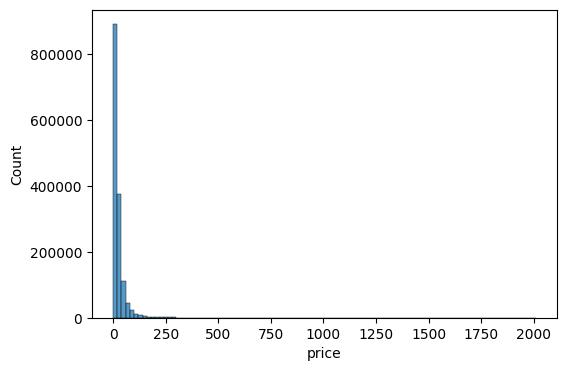

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.histplot(y_train_df, bins=100)
plt.show()

- price: 비교적 적은 가격을 가진 데이터 값에 왜곡 분포

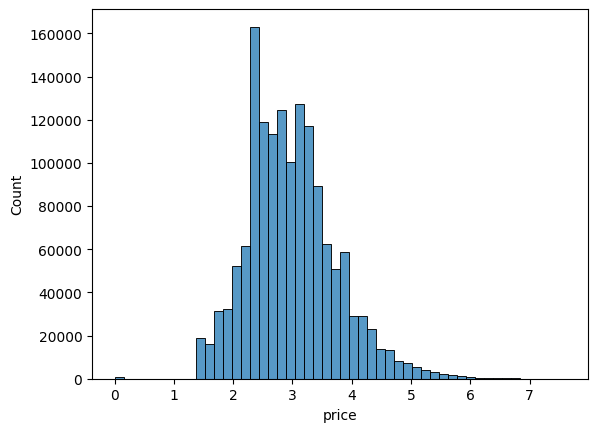

In [5]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.histplot(y_train_df, bins=50)
plt.show()

- 로그 값으로 변환 => 비교적 정규 분포에 가까운 데이터
- 데이터 세트의 price 칼럼을 원래 값에서 로그 변환된 값으로 변경

In [6]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

,price
0,2.397895
1,3.970292
2,2.397895


In [7]:
print('Shipping 값 유형:\n', mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형:\n', mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 shipping
0    819435
1    663100
Name: count, dtype: int64
item_condition_id 값 유형:
 item_condition_id
1    640549
3    432161
2    375479
4     31962
5      2384
Name: count, dtype: int64


- Shipping 칼럼: 배송비 유무 => 비교적 균일
- item_condition_id: 판매자가 제공하는 제품 상태

In [8]:
boolen_cond = mercari_df['item_description'] == 'No description yet'
print(boolen_cond.sum())

82489


- item_description: description에 대한 별도 설명이 없는 경우 'No description yet' => 82489건 적절한 값으로 변경해야 함
- category_name: '/'으로 분리된 카테고리를 하나의 문자열로 나타냄 => '/'기준 단어를 토큰화 후 별도의 피터로 저장 => 알고리즘 학습

1. category_name 'Null'이 아닌 경우: split('/')으로 대, 중, 소 분류를 분리(tokenizer 문자에 따라 문자열을 분리해 리스트로 반환)
2. category_name 'Null'인 경우: error를 except catch하여 'Other Null'값 부여
3. 판다스의 apply lambda로 반환되는 데이터 세트의 리스트 요소 => cat_due, cat_jung, cat_so

In [9]:
# apply lambda에서 호출되는 대, 중, 소 분할 함수 생성, 대, 중, 소 값을 리스트로 반환
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_Null', 'Other_Null', 'Other_Null']

# 위의 split_cat( )을 apply lambda에서 호출해 대, 중, 소 칼럼을 mercari_df에 생성.
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 개수만 추출
print('대분류 유형:\n', mercari_df['cat_dae'].value_counts())
print('중분류 개수:', mercari_df['cat_jung'].nunique())
print('소분류 개수:', mercari_df['cat_so'].nunique())

대분류 유형:
 cat_dae
Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: count, dtype: int64
중분류 개수: 114
소분류 개수: 871


- brand_name, category_name, item_description => 일괄적으로 'Other_Null'통일
- fillna() 적용 후 각 칼럼별로 Null값 없는지 mercari_df.isnull().sum() 호출해 확인: 모두 0

In [10]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

# 각 칼럼별로 Null 값 건수 확인. 모두 0이 나와야 함
mercari_df.isnull().sum()

,0
train_id,0
name,0
item_condition_id,0
category_name,0
brand_name,0
price,0
shipping,0
item_description,0
cat_dae,0
cat_jung,0




> **피처 인코딩과 피처 벡터화**
- 문자열 칼럼 중 레이블/원-핫 인코딩 수행하거나 피처 벡터화로 변환할 칼럼 선별
- 상품 가격(price) 예측 => 선형 회귀 모델, 회귀 트리 모델 적용
- 피처 벡터화 - 짧은 텍스트: Count 기반 / 긴 텍스트: TF-IDF 기반



In [11]:
print('brand name의 유형 건수:', mercari_df['brand_name'].nunique())
print(mercari_df['brand_name'].value_counts()[:5])

brand name의 유형 건수: 4810
brand_name
Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: count, dtype: int64


In [12]:
print('name의 종류 개수:', mercari_df['name'].nunique())
print('name sample 7건:\n', mercari_df['name'][:7])

name의 종류 개수: 1225273
name sample 7건:
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


- Name 속성: 유형 매우 많고, 적은 단어 위주 텍스트 형태 => Count 기반 피처 벡터화 변환
- category_name 칼럼: 대, 중, 소 분류 세 개 칼럼(cat_dae, cat_jung, cat_so) => 원-핫 인코딩
- shipping(배송비 무료 여부 0,1), item_condition_id 칼럼(상품 상태 1~5): 원-핫 인코딩

In [13]:
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 크기
print('item_description 평균 오차열 크기:', mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 오차열 크기: 145.71139703278507


,item_description
0,No description yet
1,This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.


- 평균 문자열 145자 => TF-IDF 변환

In [14]:
# name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features=50000, ngram_range=(1,3), stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:', X_name.shape)
print('item_description vectorization shape:', X_descp.shape)

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


**해야할 것**

- 희소 행렬 객체 변수(X_name, X_descp) 새로 결합해 새로운 데이터 구성
- 앞으로 인코딩 될 cat_due, cat_jung. cat_so, brand_name, shipping, item_condition_id => X_name, X_descp와 결합돼 ML 모델 실행하는 기반 데이터 세트로 재구성

**따라서**

- 인코딩 대상 칼럼도 희소 행렬 형태로 인코딩 적용 후 함께 결합
- 모든 인코딩 대상 칼럼 LabelBinarizer로 희소 행렬 형태의 원-핫 인코딩 변환
- 개별 칼럼으로 만들어진 희소 행렬 => sparse 모듈 *hstack()* 함수 이용해 결합



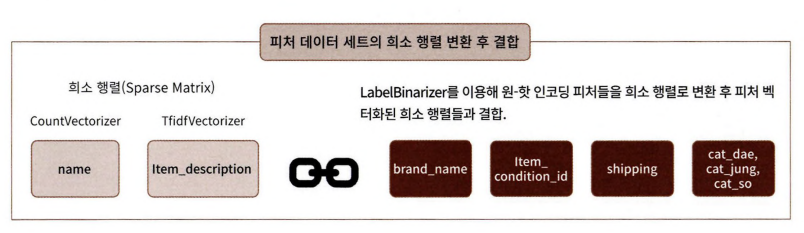

In [15]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping = LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])


# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])

lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])

lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [16]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
X_brand shape:(1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


- 피처 벡터화 변환한 데이터 세트 + 희소 인코딩 변환된 데이터 세트 => *hstack()*로 결합
- 결합한 데이터 타입, 크기만 확인 후 *gc.collect()*로 메모리에서 삭제(메모리 오류)

In [17]:
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 바로 메모리에서 삭제
del X_features_sparse
gc.collect()

<class 'scipy.sparse._csr.csr_matrix'> (1482535, 161569)


0



> **릿지 회귀 모델 구축 및 평가**
- RMSLE(Root Mean Square Logarithmic Error) 방식: 오류 값에 로그를 취해 RMSE 구하는 방식
- 학습 모델 이용한 예측된 price값 => 로그 역변환(지수 Exponential) 변환으로 원복: *evaluate_org_price(y_test, preds)*

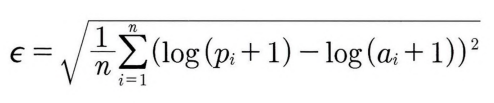


In [18]:
def rmsle(y, y_pred):
    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test, preds):

    # 원본 데이터는 log1p로 변환되었으므로 exmpm1로 원복 필요
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)

    # rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

In [21]:
import gc
from scipy.sparse import hstack


def model_train_predict(model, matrix_list):
    # scipy.sparse 모듈의 hstack을 이용해 희소 행렬 결합
    X = hstack(matrix_list).tocsr()

    X_train, X_test, y_train, y_test = train_test_split(X, mercari_df['price'],
                                                        test_size=0.2, random_state=156)

    # 모델 학습 및 예측
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    del X, X_train, X_test, y_train
    gc.collect()

    return preds, y_test

- **Ridge**: Mercari Price 회귀 예측 수행

In [22]:
linear_model = Ridge(solver = "lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description 제외 rmsle 값:', evaluate_org_price(y_test, linear_preds))


sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description 포함 rmsle 값:', evaluate_org_price(y_test, linear_preds))

Item Description 제외 rmsle 값: 0.4983990938999374
Item Description 포함 rmsle 값: 0.4680432471796771




> **LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가**
- LightGBM을 이용해 회귀 수행 => 릿지 모델 예측값, LightGBM 모델 예측값 =>  간단한 앙상블(Ensemble) 방식으로 섞어 최종 회귀 예측값 평가



In [23]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds, y_test = model_train_predict(model=lgbm_model, matrix_list=sparse_matrix_list)
print('LightGBM 값:', evaluate_org_price(y_test, lgbm_preds))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3751.610732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1068323
[LightGBM] [Info] Number of data points in the train set: 1186028, number of used features: 65338
[LightGBM] [Info] Start training from score 2.979514


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM 값: 0.4563962127849484


In [24]:
preds = lgbm_preds*0.45 + linear_preds*0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle값:',evaluate_org_price(y_test, preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle값: 0.4467272727321774


- 간단한 앙상블 방식으로 예측 성능 더 개선

#### 11 정리

- 텍스트 분석을 위한 기반 프로세스 알아보기
- 텍스트 분류, 감성 분석, 토픽 모델링, 텍스트 군집화 및 유사도 측정 => 파이썬 코드 구현

> **1. 텍스트 정규화 작업**
- 텍스트 클렌징, 대소문자 변경, 단어 토큰화, 의미 없는 단어 필터링, 어근 추출 등 피처 벡터화 진행하기 이전 수행하는 다양한 사전 작업
- BOW 대표 방식 Count 기반, TF-IDF 기반 피처 벡터화
      피처 벡터 데이터 세트 => 희소 행렬



> **2. 텍스트 분류**
- 로지스틱 회귀 적용해 문서를 지도학습 방식으로 예측 분류
- 감성 분석 => 지도학습 기반(긍정/부정 이진 분류 적용)방식, 감성 사전 Lexicon(SentiWordNet, VADER)
- 토픽 모델링: LDA(Latent Dirichlet Allocation)
- 텍스트 군집화: K-평균 군집화
- 텍스트 유사도 측정: 코사인 유사도
- 긍정/부정 이진 분류: 파이썬 한글 형태소 분석기 KoNLPy 패키지

=> 과거에는 단순히 보관용에 지나지 않았던 비정형 데이터들이 머신러닝 기법의 도입으로 새로운 데이터로서의 가치, 새로운 인사이트 제공